In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from torchvision.models import resnet50, vit_b_16, vit_b_32, vit_l_16
from tqdm.autonotebook import tqdm
from copy import deepcopy
from cka import CKACalculator
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7, 7)

/tmp/ipykernel_2002/4067761723.py:6: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
%load_ext autoreload
%autoreload 2

## Setup DataLoader and Models 

An important detail is that although we are using the Validation set for `CIFAR10`, we **shuffle** and drop the last batch. This is to ensure that 1) the batches of each epoch are mixed, and 2) each iteration has the same batch size.

In [3]:
transforms = Compose([Resize(224),ToTensor(), 
                      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

dataset = CIFAR10(root='../data/', train=False, download=True, transform=transforms)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True, drop_last=True, num_workers=4, pin_memory=True)

In [9]:
model1 = resnet50(pretrained=True).cuda()
model1.eval()
model2 = vit_b_32(pretrained=True).cuda()
model2.eval()
print('Dummy models created')

Dummy models created


## Compute CKA 

### Basic Usage 

Initializing the `CKACalculator` object will add forward hooks to both `model1` and `model2`. 
The default modules that are hooked are: 
```
_HOOK_LAYER_TYPES = (
    BasicBlock, nn.Conv2d, nn.AdaptiveAvgPool2d, nn.MaxPool2d,
    nn.MultiheadAttention, nn.Linear, nn.LayerNorm, nn.ReLU, nn.BatchNorm2d, nn.GELU) 
```
This will not add hooks to any custom implementations, the code can be modify to those purposes.

For ResNet50, a total of 126 hooks are added.
For ViT-B/32 a total of 87 hooks are added.

By default, the intermediate features are flattened with `flatten_hook_fn` and 10 epochs are run.

In [10]:
calculator = CKACalculator(model1=model1, model2=model2, dataloader=dataloader)

No hook function provided. Using flatten_hook_fn.
126 Hooks registered. Total hooks: 126
No hook function provided. Using flatten_hook_fn.
87 Hooks registered. Total hooks: 87


Now we can calculate the CKA matrix 

In [11]:
cka_output = calculator.calculate_cka_matrix()
print(f"CKA output size: {cka_output.size()}")

Epoch 9: 100%|██████████| 19/19 [02:50<00:00,  8.96s/it]


CKA output size: torch.Size([75, 158])


#### Visualize the output

Note that the returned matrix has its origin at the top left. In most papers, the CKA matrix is visualized with its origin at the bottom left. Thus, we may flip the matrix first before visualization; however, this example chooses not to.

In [12]:
cka_matrix = cka_output.cpu().numpy()

Text(0, 0.5, 'ViT B/32 Layers')

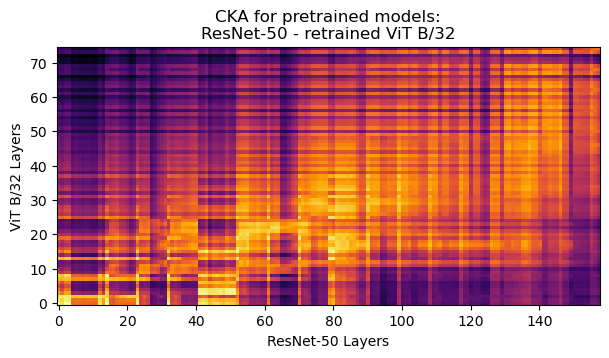

In [ ]:
plt.Figure()
plt.imshow(cka_matrix, cmap='inferno',origin='lower')
plt.title("CKA for pretrained models:\nResNet-50 - retrained ViT-B/32")
plt.xlabel("ResNet-50 Layers")
plt.ylabel("ViT B/32 Layers")

# Debugging

In [4]:
model1 = vit_l_16(pretrained=True).cuda()
model1.eval()
model2 = vit_l_16(pretrained=True).cuda()
model2.eval()
print('Dummy models created')

/home/tvald/anaconda3/envs/a4-dl-env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tvald/anaconda3/envs/a4-dl-env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_L_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_L_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Dummy models created


In [ ]:
calculator = CKACalculator(
    model1=model1,
    model2=model2,
    dataloader=dataloader,
    num_epochs=1,
    group_size= 256,
    epsilon = 1e-3
    )

No hook function provided. Using flatten_hook_fn.
171 Hooks registered. Total hooks: 171
No hook function provided. Using flatten_hook_fn.
171 Hooks registered. Total hooks: 171


In [5]:
cka_output = calculator.calculate_cka_matrix()
print(f"CKA output size: {cka_output.size()}")

Epoch 0: 100%|██████████| 19/19 [15:52<00:00, 50.12s/it]


CKA output size: torch.Size([147, 147])


In [6]:
cka_matrix = cka_output.cpu().numpy()

Text(0, 0.5, 'ViT B/32 Layers')

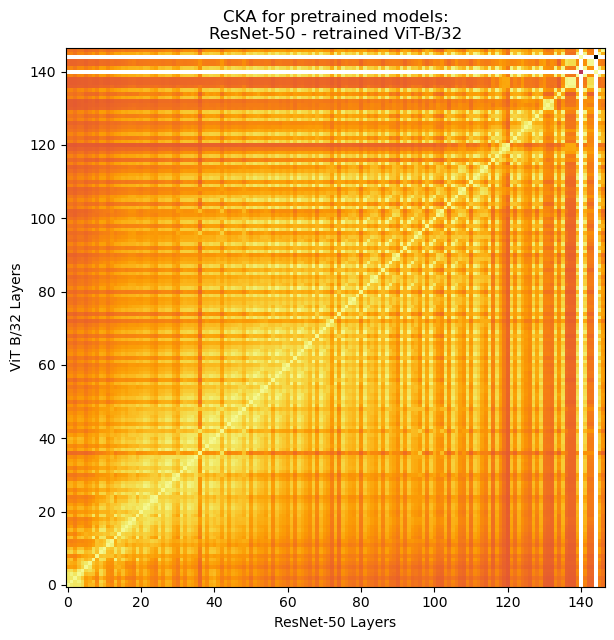

In [7]:
plt.Figure()
plt.imshow(cka_matrix, cmap='inferno',origin='lower')
plt.title("CKA for pretrained models:\nResNet-50 - retrained ViT-B/32")
plt.xlabel("ResNet-50 Layers")
plt.ylabel("ViT B/32 Layers")

In [8]:
cka_matrix[0,:]

array([1.        , 0.9073318 , 0.8797494 , 0.88906634, 0.8176957 ,
       0.4741097 , 0.6055551 , 0.612019  , 0.37634674, 0.7249651 ,
       0.60918534, 0.38829184, 0.33945027, 0.59657216, 0.35999966,
       0.5598843 , 0.3964773 , 0.34908366, 0.31158027, 0.5570347 ,
       0.40694997, 0.5519475 , 0.45386922, 0.34602413, 0.3035392 ,
       0.5155324 , 0.37709486, 0.5617931 , 0.5375631 , 0.32643023,
       0.25306302, 0.48872712, 0.33497116, 0.51628786, 0.48044968,
       0.38713047, 0.17197116, 0.4753701 , 0.3635427 , 0.5530044 ,
       0.5978115 , 0.48005477, 0.33660847, 0.4410195 , 0.35117602,
       0.47101173, 0.4390687 , 0.40239817, 0.32818237, 0.39789286,
       0.24349241, 0.40059423, 0.330927  , 0.31471315, 0.25275263,
       0.3447057 , 0.20327193, 0.37328783, 0.31201816, 0.27879316,
       0.23777021, 0.32028663, 0.22827397, 0.3602886 , 0.31710705,
       0.26242614, 0.20670609, 0.30472267, 0.18272573, 0.34223273,
       0.27381253, 0.228012  , 0.13057497, 0.28350118, 0.14186

In [49]:
calculator.reset()
torch.cuda.empty_cache()

171 handles removed.
171 handles removed.


In [50]:
calculator = CKACalculator(
    model1=model1, model2=model2, 
    dataloader=dataloader, num_epochs=1, group_size=256,
    epsilon=1e-1
    )

No hook function provided. Using flatten_hook_fn.
171 Hooks registered. Total hooks: 171
No hook function provided. Using flatten_hook_fn.
171 Hooks registered. Total hooks: 171


In [51]:
cka_output = calculator.calculate_cka_matrix()
print(f"CKA output size: {cka_output.size()}")

Epoch 0:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 0: 100%|██████████| 39/39 [12:47<00:00, 19.69s/it]

CKA output size: torch.Size([147, 147])


In [54]:
cka_matrix = cka_output.cpu().numpy()

Text(0, 0.5, 'ViT B/32 Layers')

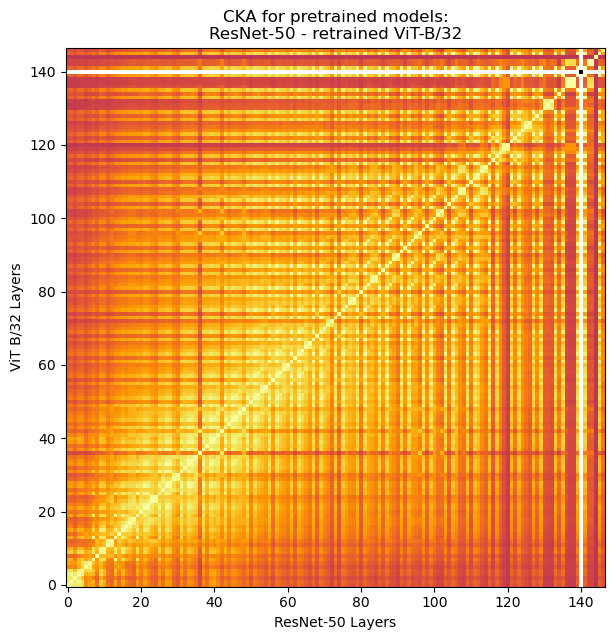

In [55]:
plt.Figure()
plt.imshow(cka_matrix, cmap='inferno',origin='lower')
plt.title("CKA for pretrained models:\nResNet-50 - retrained ViT-B/32")
plt.xlabel("ResNet-50 Layers")
plt.ylabel("ViT B/32 Layers")

In [14]:
a = calculator.extract_layer_list_from_hook_manager()

In [18]:
calculator.module_names_X

['conv_proj',
 'encoder.layers.encoder_layer_0.ln_1',
 'encoder.layers.encoder_layer_0.self_attention',
 'encoder.layers.encoder_layer_0.ln_2',
 'encoder.layers.encoder_layer_0.mlp.0',
 'encoder.layers.encoder_layer_0.mlp.1',
 'encoder.layers.encoder_layer_0.mlp.3',
 'encoder.layers.encoder_layer_1.ln_1',
 'encoder.layers.encoder_layer_1.self_attention',
 'encoder.layers.encoder_layer_1.ln_2',
 'encoder.layers.encoder_layer_1.mlp.0',
 'encoder.layers.encoder_layer_1.mlp.1',
 'encoder.layers.encoder_layer_1.mlp.3',
 'encoder.layers.encoder_layer_2.ln_1',
 'encoder.layers.encoder_layer_2.self_attention',
 'encoder.layers.encoder_layer_2.ln_2',
 'encoder.layers.encoder_layer_2.mlp.0',
 'encoder.layers.encoder_layer_2.mlp.1',
 'encoder.layers.encoder_layer_2.mlp.3',
 'encoder.layers.encoder_layer_3.ln_1',
 'encoder.layers.encoder_layer_3.self_attention',
 'encoder.layers.encoder_layer_3.ln_2',
 'encoder.layers.encoder_layer_3.mlp.0',
 'encoder.layers.encoder_layer_3.mlp.1',
 'encoder.layer

In [56]:
import numpy as np

In [57]:
# Get indexes of layers with nan values in the numpy cka matrix
nan_indexes = np.argwhere(np.isnan(cka_matrix[0,:]))
nan_indexes

array([[140]])

In [58]:
# Get submatrix without nan values
cka_matrix_no_nan = np.delete(cka_matrix, nan_indexes, axis=1)
cka_matrix_no_nan = np.delete(cka_matrix_no_nan, nan_indexes, axis=0)
cka_matrix_no_nan

array([[1.0000000e+00, 9.0700632e-01, 8.7919778e-01, ..., 4.1264849e-04,
        2.8555313e-01, 1.9710796e-01],
       [9.0700632e-01, 1.0000000e+00, 8.8551325e-01, ..., 6.7934883e-04,
        3.1254521e-01, 2.0657824e-01],
       [8.7919790e-01, 8.8551325e-01, 1.0000000e+00, ..., 5.3167605e-04,
        2.1617244e-01, 1.7207365e-01],
       ...,
       [3.8837502e-04, 5.8229896e-04, 4.2534087e-04, ..., 1.0000000e+00,
        1.9321152e-03, 6.5908569e-04],
       [2.8555313e-01, 3.1254527e-01, 2.1617244e-01, ..., 1.3376185e-03,
        1.0000000e+00, 5.7878542e-01],
       [1.9710794e-01, 2.0657828e-01, 1.7207366e-01, ..., 6.5908564e-04,
        5.7878554e-01, 1.0000000e+00]], dtype=float32)

Text(0, 0.5, 'ViT B/32 Layers')

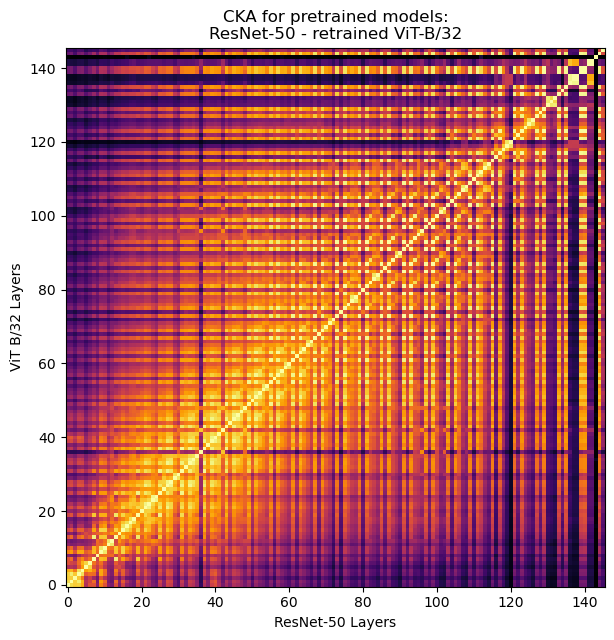

In [59]:
plt.Figure()
plt.imshow(cka_matrix_no_nan, cmap='inferno',origin='lower')
plt.title("CKA for pretrained models:\nResNet-50 - retrained ViT-B/32")
plt.xlabel("ResNet-50 Layers")
plt.ylabel("ViT B/32 Layers")